In [ ]:


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import random
import numpy as np

# ==========================
# Load Dataset Efficiently
# ==========================
DATASET_PATH = "/content/drive/MyDrive/project phase2/subset"
IMG_SIZE = (128, 128)
BATCH_SIZE = 16
NUM_CLASSES = 3

def load_image(path):
    img = tf.io.read_file(path)

    try:
        img = tf.image.decode_jpeg(img, channels=3)
    except:
        img = tf.image.decode_png(img, channels=3)

    img = tf.image.resize(img, IMG_SIZE) / 255.0  # Normalize
    return img

def load_dataset(dataset_path):
    image_paths, labels = [], []
    class_names = sorted(os.listdir(dataset_path))

    label_map = {name: idx for idx, name in enumerate(class_names)}
    valid_extensions = {".jpg", ".jpeg", ".png"}

    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        for image in os.listdir(class_path):
            if os.path.splitext(image)[1].lower() in valid_extensions:
                image_paths.append(os.path.join(class_path, image))
                labels.append(label_map[class_name])

    return image_paths, labels, label_map

# Load dataset
image_paths, labels, label_map = load_dataset(DATASET_PATH)

# ==========================
# Generate Image Pairs for Siamese Network
# ==========================
def generate_pairs(image_paths, labels, num_classes):
    pairs = []
    labels_pairs = []
    num_images = len(image_paths)

    labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes)  # One-hot encode labels

    for i in range(num_images):
        img1 = image_paths[i]
        label1 = labels[i]

        # Positive Pair (Same Class)
        positive_idx = random.choice([j for j in range(num_images) if labels[j] == label1 and j != i])
        img2_pos = image_paths[positive_idx]
        pairs.append((img1, img2_pos))
        labels_pairs.append(labels_one_hot[i])  # One-hot encoded class label

        # Negative Pair (Different Class)
        negative_idx = random.choice([j for j in range(num_images) if labels[j] != label1])
        img2_neg = image_paths[negative_idx]
        pairs.append((img1, img2_neg))
        labels_pairs.append(labels_one_hot[negative_idx])  # One-hot encoded class label

    return pairs, np.array(labels_pairs)

pairs, labels_pairs = generate_pairs(image_paths, labels, NUM_CLASSES)

# ==========================
# Convert to tf.data Pipeline
# ==========================
def process_pair(img1_path, img2_path, label):
    img1 = load_image(img1_path)
    img2 = load_image(img2_path)
    return (img1, img2), label

dataset = tf.data.Dataset.from_tensor_slices((pairs, labels_pairs))
dataset = dataset.map(lambda pair, label: process_pair(pair[0], pair[1], label), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ==========================
# Siamese Network Model
# ==========================
def build_siamese_model(input_shape, num_classes):
    base_model = keras.applications.MobileNetV2(weights=None, input_shape=input_shape, include_top=False, pooling="avg")

    input1 = keras.Input(shape=input_shape)
    input2 = keras.Input(shape=input_shape)

    embedding1 = base_model(input1)
    embedding2 = base_model(input2)

    l1 = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([embedding1, embedding2])
    output = layers.Dense(num_classes, activation="softmax")(l1)  # Softmax for 3-class classification

    model = keras.Model(inputs=[input1, input2], outputs=output)
    return model

# Compile Model
input_shape = (128, 128, 3)
siamese_model = build_siamese_model(input_shape, NUM_CLASSES)
siamese_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# ==========================
# Train Siamese Network
# ==========================
history = siamese_model.fit(dataset, epochs=80, validation_data=dataset)


Epoch 1/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 115s 516ms/step - accuracy: 0.4614 - loss: 1.1031 - val_accuracy: 0.3383 - val_loss: 1.0986
Epoch 2/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.4428 - loss: 1.0853 - val_accuracy: 0.3383 - val_loss: 1.0986
Epoch 3/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step - accuracy: 0.4534 - loss: 1.0428 - val_accuracy: 0.3383 - val_loss: 1.0985
Epoch 4/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 0.4500 - loss: 1.0618 - val_accuracy: 0.3383 - val_loss: 1.0986
Epoch 5/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 294ms/step - accuracy: 0.4746 - loss: 1.0187 - val_accuracy: 0.3261 - val_loss: 1.0987
Epoch 6/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 279ms/step - accuracy: 0.5066 - loss: 0.9822 - val_accuracy: 0.3261 - val_loss: 1.0987
Epoch 7/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 288ms/step - accuracy: 0.5001 - loss: 0.9942 - val_accuracy: 0.3261 - val_loss: 1.0987
Epoch 8/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 193ms/step - accuracy: 0.5485 - loss: 

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.8946 - loss: 0.3098
Test Accuracy: 86.78%
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6

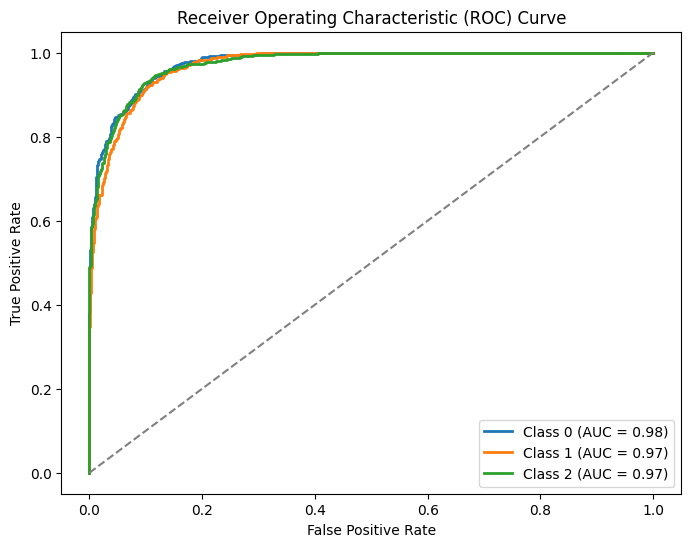

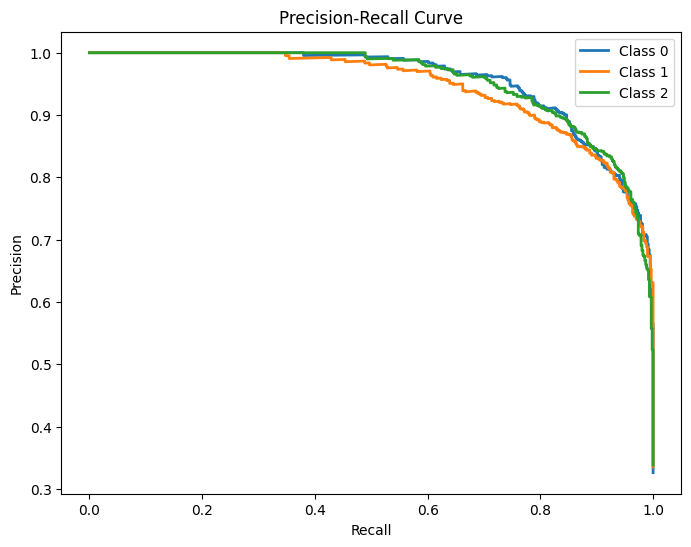

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
# ==========================
# Evaluate Model on Test Data
# ==========================
test_loss, test_acc = siamese_model.evaluate(dataset, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# ==========================
# Get Predictions
# ==========================
y_true = []
y_pred = []

for (img1, img2), label in dataset:
    preds = siamese_model.predict([img1, img2])  # Get model predictions
    y_pred.extend(preds)  # Store predictions
    y_true.extend(label.numpy())  # Store ground truth labels

y_pred = np.array(y_pred)
y_true = np.array(y_true)

if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)  # Convert one-hot labels to class indices

y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class indices

# ==========================
# ROC Curve for Multi-Class
# ==========================
n_classes = len(np.unique(y_true))
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# ==========================
# Precision-Recall Curve for Multi-Class
# ==========================
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve((y_true == i).astype(int), y_pred[:, i])
    plt.plot(recall, precision, lw=2, label=f"Class {i}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━

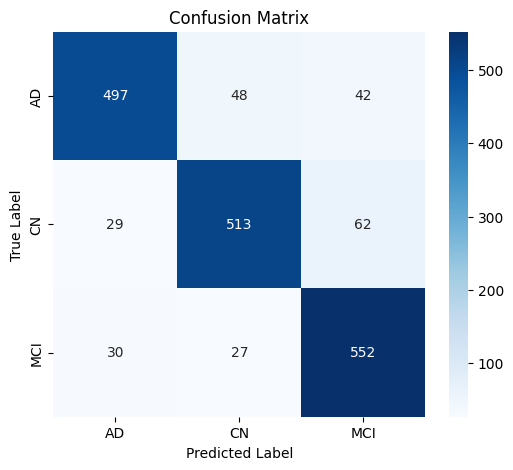

Classification Report:
              precision    recall  f1-score   support

          AD       0.89      0.85      0.87       587
          CN       0.87      0.85      0.86       604
         MCI       0.84      0.91      0.87       609

    accuracy                           0.87      1800
   macro avg       0.87      0.87      0.87      1800
weighted avg       0.87      0.87      0.87      1800



In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ==========================
# Predict on Test Dataset
# ==========================
y_true = []
y_pred = []

for (img1, img2), labels in dataset:
    preds = siamese_model.predict([img1, img2])
    y_pred.extend(np.argmax(preds, axis=1))  # Convert softmax output to class index
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # True labels

# ==========================
# Compute Confusion Matrix
# ==========================
cm = confusion_matrix(y_true, y_pred)
class_names = list(label_map.keys())  # Get class names from label mapping

# ==========================
# Plot Confusion Matrix
# ==========================
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ==========================
# Print Classification Report
# ==========================
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
